In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shap

In [ ]:
# read train data
train_df= pd.read_csv('train.csv')
#read test data
test_df = pd.read_csv('test.csv')
train_df.head()

In [42]:
# hin = pd.read_csv("Cache/Embeddings/lda_bn.csv")
# whole_data = pd.read_csv("Data/cleaned bangla.csv")
# le = LabelEncoder()
# y = pd.DataFrame(le.fit_transform(whole_data["Sub-task A"]))
# X_train, X_test, Y_train, Y_test = train_test_split(hin, y, test_size=0.3, random_state=2)
# train_df=pd.DataFrame(X_train)
# test_df=pd.DataFrame(X_test)

In [90]:
x = pd.read_csv("Cache/Embeddings/tfidf_ben.csv")
# y = pd.read_csv("Data/cleaned english.csv")["Sub-task A"]
y = pd.read_csv("Data/y_ben_oversampled.csv", header=None)
le = LabelEncoder()
y = le.fit_transform(y.iloc[:, 0])
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=4)
train_df=pd.DataFrame(X_train)
test_df=pd.DataFrame(X_test)

In [43]:
train_df.isna().any().any(), test_df.isna().any().any()

(False, False)

In [56]:
train_df.head()

,na,ranu,ta,অন,আগ,আছ,আপন,আব,আম,আমর,...,যদ,রণ,রত,লত,সত,সব,সম,হব,হল,হয়
5347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
5541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.482488,...,0.488295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.411222,0.0
2145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1513,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
6884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [ ]:
train_df.drop(['Y'], axis=1, inplace=True)
test_df.drop(['Y'], axis=1, inplace=True)

In [91]:
train_df['dataset_label'] = 1
test_df['dataset_label'] = 0
combined_data = pd.concat([train_df, test_df], axis = 0)

In [92]:
def adversarial_validation(dataset, train_data, test_data):
    dataset = dataset.sample(frac=1)
    av_train = dataset[:len(train_data)]
    av_test = dataset[len(train_data):]
    return av_train, av_test
av_train, av_test = adversarial_validation(combined_data, train_df, test_df)
train_data = Pool(
    data=av_train.drop('dataset_label',1),
    label=av_train['dataset_label']
)
remaining_data = Pool(
    data=av_test.drop('dataset_label',1),
    label=av_test['dataset_label']
)
col_to_list = combined_data.columns.tolist()
col_to_list.remove('dataset_label')
metrics = {
    'iterations': 500,
    'eval_metric': 'AUC'
}
model = CatBoostClassifier(**metrics)
_ = model.fit(train_data, eval_set=remaining_data, plot=False, verbose=False)

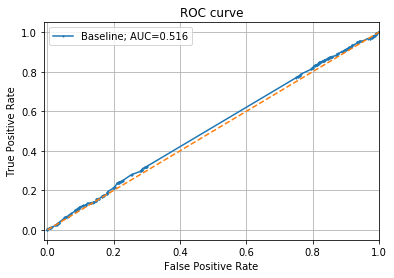

In [93]:
def rocgraph(y_trues, y_preds, labels, x_max=1.0):
    fig, ax = plt.subplots()
    for i, y_pred in enumerate(y_preds):
        y_true = y_trues[i]
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        ax.plot(fpr, tpr, label='%s; AUC=%.3f' % (labels[i], auc), marker='o', markersize=1)
    ax.legend()
    ax.grid()
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax.set_title('ROC curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_xlim([-0.01, x_max])
    _ = ax.set_ylabel('True Positive Rate')
rocgraph(
    [remaining_data.get_label().astype('int')],
    [model.predict_proba(remaining_data)[:,1]],
    ['Baseline']
)

Glyph 2476 missing from current font.
Glyph 2472 missing from current font.
Glyph 2438 missing from current font.
Glyph 2455 missing from current font.
Glyph 2488 missing from current font.
Glyph 2478 missing from current font.
Glyph 2447 missing from current font.
Glyph 2453 missing from current font.
Glyph 2468 missing from current font.
Glyph 2474 missing from current font.
Glyph 2480 missing from current font.
Glyph 2463 missing from current font.
Glyph 2489 missing from current font.
Glyph 2482 missing from current font.
Glyph 2469 missing from current font.
Glyph 2476 missing from current font.
Glyph 2472 missing from current font.
Glyph 2438 missing from current font.
Glyph 2455 missing from current font.
Glyph 2488 missing from current font.
Glyph 2478 missing from current font.
Glyph 2447 missing from current font.
Glyph 2453 missing from current font.
Glyph 2468 missing from current font.
Glyph 2474 missing from current font.
Glyph 2480 missing from current font.
Glyph 2463 m

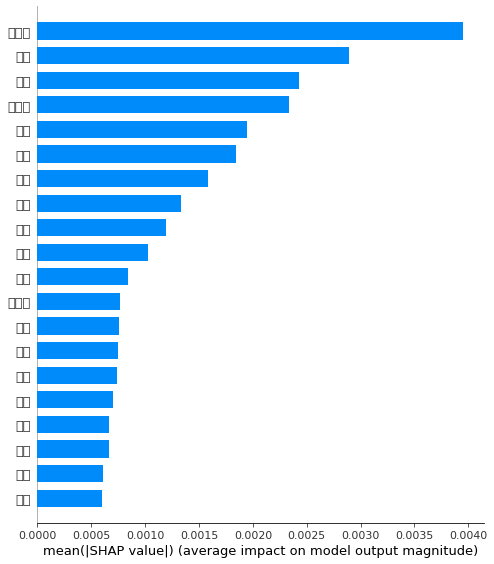

In [94]:
def plot_features(model, remaining_data, features):
    featurevalues = model.get_feature_importance(remaining_data, type='ShapValues')
    expected_value = featurevalues[0,-1]
    featurevalues = featurevalues[:,:-1]
    shap.summary_plot(featurevalues, remaining_data, feature_names=features, plot_type='bar')
plot_features(model, remaining_data, combined_data.columns)

In [95]:
train_df.shape, test_df.shape

((5455, 49), (2339, 49))

In [96]:
train_df['Y'] = Y_train
train_df.drop(columns=['dataset_label'], inplace=True)
train_df.head()

,na,ranu,ta,অন,আগ,আছ,আপন,আব,আম,আমর,...,রণ,রত,লত,সত,সব,সম,হব,হল,হয়,Y
1354,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2443,0.0,0.0,0.0,0.747415,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.664358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5399,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2613,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2992,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [97]:
train_df.to_csv("Data/ben_train_tfidf.csv", index=False)

In [98]:
test_df['Y'] = Y_test
test_df.drop(columns=['dataset_label'], inplace=True)
test_df.head()

,na,ranu,ta,অন,আগ,আছ,আপন,আব,আম,আমর,...,রণ,রত,লত,সত,সব,সম,হব,হল,হয়,Y
6760,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4975,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
158,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.754948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2006,0.0,0.710011,0.0,0.0,0.0,0.0,0.70419,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4485,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [54]:
test_df.to_csv("Data/ben_test_tfidf.csv", index=False)